<a href="https://colab.research.google.com/github/Prasannasoff/CODSOFT/blob/main/movie_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
train_path = "/content/train_data.txt"


In [ ]:
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')


In [ ]:
train_data.head(3)

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...


In [ ]:
test_path="/content/test_data.txt"

In [ ]:
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')

In [ ]:
test_data.head(3)

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...


In [ ]:
test_soln_path = "/content/test_data_solution.txt"

In [ ]:
test_soln_data = pd.read_csv(test_soln_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_soln_data.drop(test_soln_data.columns[[0, 2]], axis=1, inplace=True)
test_soln_data.rename(columns = {'Title':'Actual Genre'}, inplace = True)
test_soln_data.head(3)

,Actual Genre
1,thriller
2,comedy
3,documentary


In [ ]:
#Count each genre value
train_data.Genre.value_counts()

 drama           4389
 documentary     4231
 comedy          2399
 short           1690
 horror           693
 thriller         518
 action           419
 western          339
 reality-tv       293
 family           272
 adventure        262
 music            243
 sci-fi           221
 romance          213
 adult            189
 animation        170
 crime            135
 sport            129
 talk-show        128
 fantasy          111
 mystery          104
 musical           86
 biography         77
 history           75
 game-show         64
 news              58
 war               44
Name: Genre, dtype: int64

<ipython-input-22-e3967934d931>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette='viridis')


Text(0, 0.5, 'Distribution of Genres')

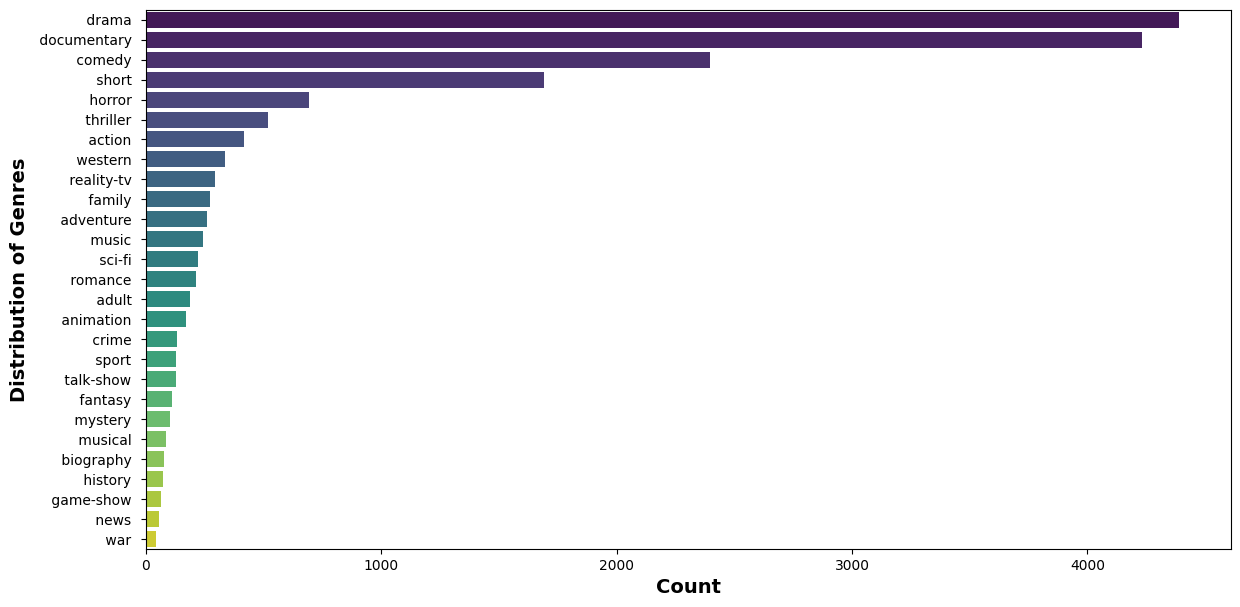

In [ ]:
plt.figure(figsize=(14, 7))
sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Distribution of Genres', fontsize=14, fontweight='bold')

<ipython-input-23-3b418856404e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts, palette='mako')


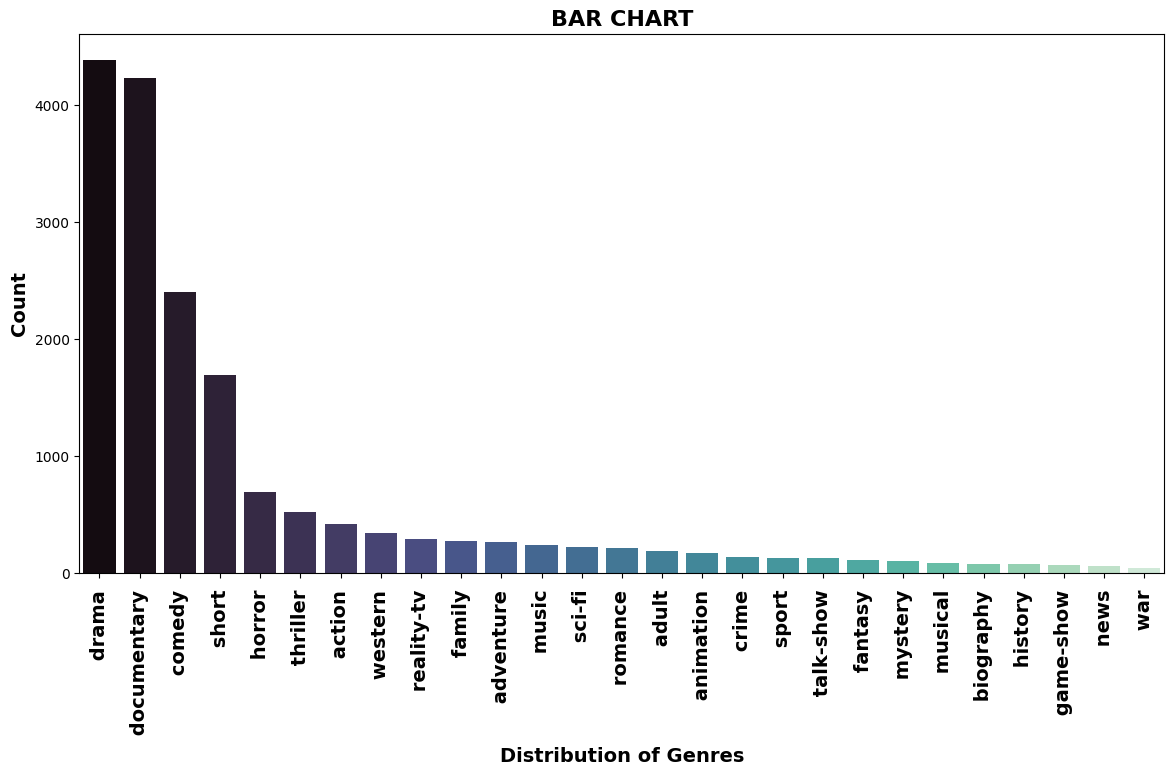

In [ ]:
# Plot the distribution of genres using a bar plot
plt.figure(figsize=(14, 7))
counts = train_data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='mako')
plt.xlabel('Distribution of Genres', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('BAR CHART', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17552 entries, 1 to 17552
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        17552 non-null  object
 1   Genre        17552 non-null  object
 2   Description  17552 non-null  object
dtypes: object(3)
memory usage: 548.5+ KB


In [ ]:
#Finda any null value
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

In [ ]:
# Droping the redundant data
print("shape before drop nulls",train_data.shape)
train_data = train_data.drop_duplicates()
print("shape after drop nulls",train_data.shape)

shape before drop nulls (17552, 4)
shape after drop nulls (17552, 4)


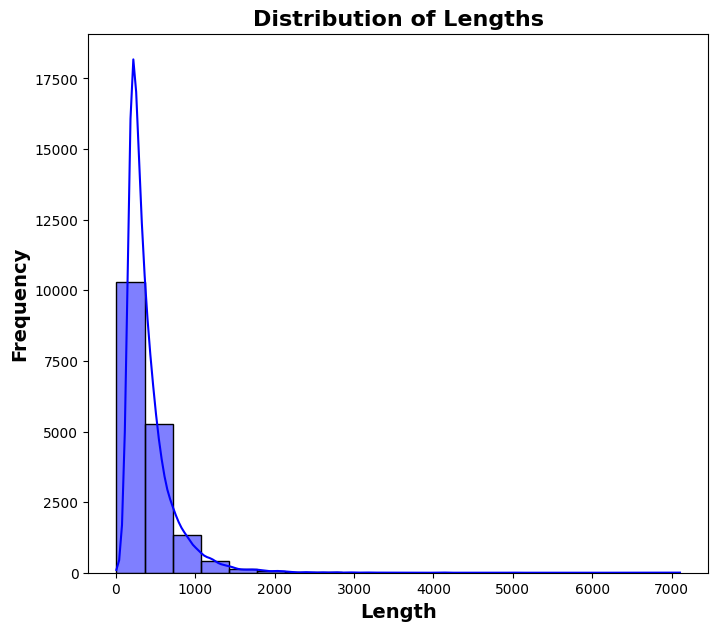

In [ ]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

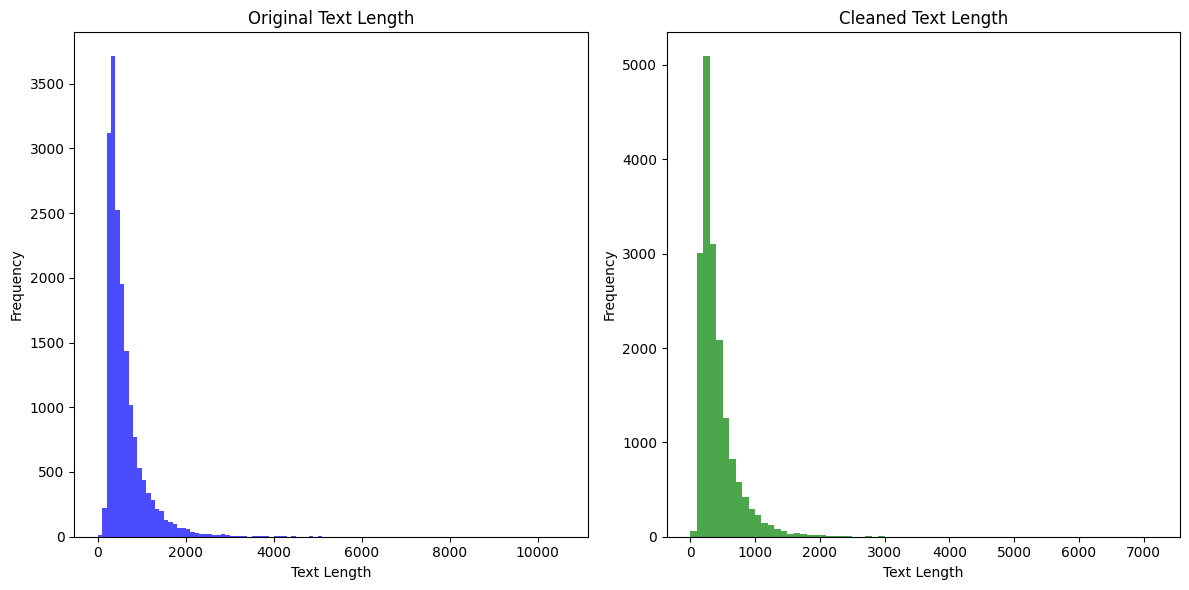

In [ ]:
# Create histograms to visualize the distribution of text lengths before and after cleaning

# Set up the figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = train_data['Description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Subplot 2: Cleaned text length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = train_data['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

In [ ]:
# Split the data into training and validation sets
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize and train a Logistic Regression Classifier
clf_logreg = LogisticRegression(multi_class='multinomial', solver='sag')
clf_logreg.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = clf_logreg.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.5160922814013101
               precision    recall  f1-score   support

      action        0.00      0.00      0.00        96
       adult        0.00      0.00      0.00        35
   adventure        1.00      0.02      0.03        58
   animation        0.00      0.00      0.00        31
   biography        0.00      0.00      0.00        15
      comedy        0.47      0.50      0.48       464
       crime        0.00      0.00      0.00        32
 documentary        0.58      0.89      0.71       846
       drama        0.46      0.78      0.58       893
      family        0.00      0.00      0.00        45
     fantasy        0.00      0.00      0.00        25
   game-show        1.00      0.08      0.15        12
     history        0.00      0.00      0.00        12
      horror        0.84      0.28      0.42       148
       music        0.67      0.12      0.21        48
     musical        0.00      0.00      0.00        14
     mystery        0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
accuracy_logreg = accuracy_score(y_val, y_pred)
accuracy_logreg

0.5160922814013101

In [ ]:
# Use the trained model to make predictions on the test data
X_test_predictions = clf_logreg.predict(X_test)
test_data['Predicted_Genre_LR'] = X_test_predictions

In [ ]:
# Save the test_data DataFrame with predicted genres to a CSV file
test_data.to_csv('predicted_genres.csv', index=False)

# Add actual genre column to predicted dataFrame
extracted_col = test_soln_data["Actual Genre"]
test_data.insert(5, "Actual Genre", extracted_col)

In [ ]:
# Display the 'test_data' DataFrame with predicted and actual genres
test_data.head()

,Id,Title,Description,Text_cleaning,Predicted_Genre_LR,Actual Genre
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...,drama,NaN
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...,drama,thriller
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...,documentary,comedy
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...,drama,documentary
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...,drama,drama


In [ ]:
movie_description = input("Enter the movie description: ")

# Clean the input description
cleaned_description = clean_text(movie_description)

# Transform the cleaned description using the TF-IDF vectorizer
X_test = tfidf_vectorizer.transform([cleaned_description])

# Predict the genre using the trained logistic regression model
predicted_genre = clf_logreg.predict(X_test)

# Print the predicted genre
print("Predicted Genre:", predicted_genre[0])

Enter the movie description: autobiography of abdulkalam
Predicted Genre:  documentary 
